**Importing the necessary dependencies :**
we import all the necessary libraries that we will use in our project.

In [ ]:
!pip install wordcloud
# utilities :
import re # regular expression library
import numpy as np
import pandas as pd

# plotting :
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk :
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')

# sklearn :
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# time library :
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Reading and Loading the Dataset :**
we  start by collecting the data on which we are going to work. In our case, we will import our data from a .csv file.

In [ ]:
df=pd.read_csv('/content/Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative




- **textID**: A unique identifier for each text entry.
- **text**: The original content of the text.
- **selected_text**: The portion of the text that was selected or highlighted.
- **sentiment**: The sentiment classification or label for the text, such as positive, negative, or neutral.

**Exploratory Data Analysis :**

we analyze a sample, we look for the shape of the dataset, the column names, the data type information, we check if there are null values



In [ ]:
# Display the column names of our dataset :
df.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [ ]:
# Display the number of records is our dataset :
print('length of data is', len(df))

length of data is 27481


In [ ]:
df.shape

(27481, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.dtypes

,0
textID,object
text,object
selected_text,object
sentiment,object


In [ ]:
# Checking for Null values :
df.isnull().sum()

,0
textID,0
text,1
selected_text,1
sentiment,0


In [ ]:
# Drop rows with any null values
df= df.dropna()

In [ ]:
# Rows and columns in the dataset :
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   4
Count of rows in the data is:   27480


In [ ]:
# Checking unique Target Values :
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

**Data Visualization of Target Variables :**

In [ ]:
df.groupby('sentiment').count()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,7781
neutral,11117,11117,11117
positive,8582,8582,8582


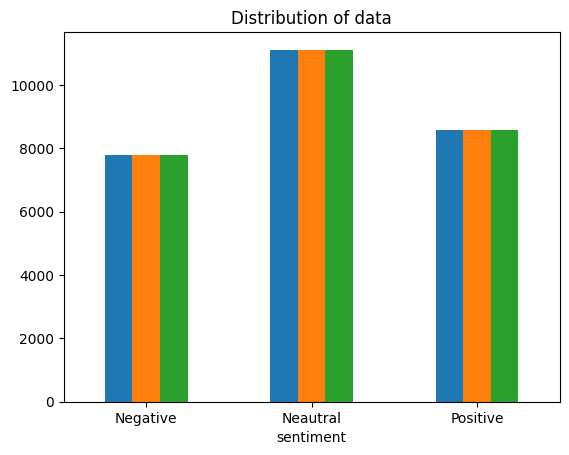

In [ ]:
# Plotting the distribution for dataset :
ax = df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
# Naming 0 -> Negative , and 4 -> Positive
ax.set_xticklabels(['Negative','Neautral','Positive'], rotation=0)

# Storing data in lists :
text, sentiment = list(df['text']), list(df['sentiment'])

<Axes: xlabel='sentiment', ylabel='count'>

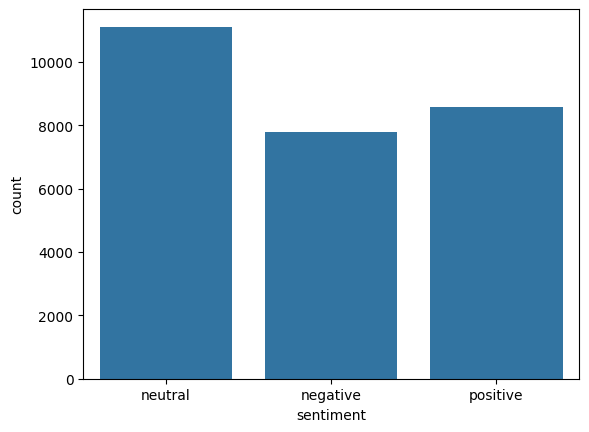

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=df)

**Data Preprocessing  :**

Before training the model, we will preprocess the dataset by:

- Removing stop words.
- Eliminating emojis.
- Converting all text to lowercase for improved consistency.
- Cleaning punctuation to minimize unnecessary noise.
- Removing repeated characters and URLs, which are not crucial for analysis.

Additionally, we will carry out:

- **Stemming**: Reducing words to their base or root form.
- **Lemmatization**: Converting derived words to their fundamental lemma for more accurate results.


In [ ]:
# Selecting the text and Target column for our further analysis :
# Map sentiment labels to numeric values
df["target"] = df["sentiment"].apply(lambda x: 1 if x == "positive"
                                             else (2 if x == "neutral"
                                                   else 0))

# Select the relevant columns for further analysis
data = df[['text', 'target']]

# Display the first few rows of the selected data
print(data.head())

                                                text  target
0                I`d have responded, if I were going       2
1      Sooo SAD I will miss you here in San Diego!!!       0
2                          my boss is bullying me...       0
3                     what interview! leave me alone       0
4   Sons of ****, why couldn`t they put them on t...       0


In [ ]:
data["target"].unique()

array([2, 0, 1])

Sentiment Mapping:

1 for "positive"
0 for "negative"
2 for "neutral"

In [ ]:
# Separating positive, negative, and neutral tweets
data_pos = data[data['target'] == 1]  # Positive tweets
data_neg = data[data['target'] == 0]  # Negative tweets
data_neu = data[data['target'] == 2]  # Neutral tweets

# Display the first few rows of each DataFrame to verify
print("Positive Tweets:")
print(data_pos.head())

print("\nNegative Tweets:")
print(data_neg.head())

print("\nNeutral Tweets:")
print(data_neu.head())


Positive Tweets:
                                                 text  target
6   2am feedings for the baby are fun when he is a...       1
9    Journey!? Wow... u just became cooler.  hehe....       1
11  I really really like the song Love Story by Ta...       1
21  Playing Ghost Online is really interesting. Th...       1
25  the free fillin` app on my ipod is fun, im add...       1

Negative Tweets:
                                                 text  target
1       Sooo SAD I will miss you here in San Diego!!!       0
2                           my boss is bullying me...       0
3                      what interview! leave me alone       0
4    Sons of ****, why couldn`t they put them on t...       0
12       My Sharpie is running DANGERously low on ink       0

Neutral Tweets:
                                                 text  target
0                 I`d have responded, if I were going       2
5   http://www.dothebouncy.com/smf - some shameles...       2
7                 

In [ ]:
# Combining positive, negative, and neutral tweets
dataset = pd.concat([data_pos, data_neg, data_neu])

# Display the first few rows of the combined dataset to verify
print(dataset.head())


                                                 text  target
6   2am feedings for the baby are fun when he is a...       1
9    Journey!? Wow... u just became cooler.  hehe....       1
11  I really really like the song Love Story by Ta...       1
21  Playing Ghost Online is really interesting. Th...       1
25  the free fillin` app on my ipod is fun, im add...       1


In [ ]:
# Quick view of how our data looks:
dataset['text'].tail()

,text
27468,"few grilled mushrooms and olives, feta cheese ..."
27469,94 more days till BH comes back to LA
27471,"i`m defying gravity. and nobody in alll of oz,..."
27473,in spoke to you yesterday and u didnt respond...
27480,All this flirting going on - The ATG smiles...


In [ ]:
# Making statement text in lower case :
dataset['text'] = dataset['text'].str.lower()
dataset['text'].tail()

,text
27468,"few grilled mushrooms and olives, feta cheese ..."
27469,94 more days till bh comes back to la
27471,"i`m defying gravity. and nobody in alll of oz,..."
27473,in spoke to you yesterday and u didnt respond...
27480,all this flirting going on - the atg smiles...


In [ ]:
# Defining set containing all stopwords in English :
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before',
                'being', 'below', 'between', 'both', 'by', 'can', 'd', 'did', 'do',
                'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from',
                'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                'into', 'is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'on', 'once',
                'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'own', 're',
                's', 'same', 'she', "shes", 'should', "shouldve", 'so', 'some', 'such',
                't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
                'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was',
                'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom',
                'why', 'will', 'with', 'won', 'y', 'you', "youd", "youll", "youre",
                "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
# Cleaning and removing the above stop words list from the tweet text :
STOPWORDS = set(stopwordlist)


def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

,text
6,"['am', 'feedings', 'baby', 'fun', 'smiles', 'c..."
9,"['journey', 'wow', 'u', 'became', 'cooler', 'h..."
11,"['really', 'really', 'like', 'song', 'love', '..."
21,"['playing', 'ghost', 'online', 'really', 'inte..."
25,"['free', 'fillin', 'app', 'ipod', 'fun', 'im',..."


In [ ]:
#  Cleaning and removing punctuations :
import string

english_punctuations = string.punctuation
punctuations_list = english_punctuations


def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


dataset['text'] = dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

,text
27468,grilled mushrooms olives feta cheese coffee br...
27469,94 days till bh comes back la
27471,im defying gravity nobody alll oz no wizard wa...
27473,spoke yesterday u didnt respond girl wassup th...
27480,flirting going atg smiles yay hugs


In [ ]:
# Cleaning and removing repeating characters :
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)


dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

,text
27468,grilled mushrooms olives feta cheese coffee br...
27469,94 days till bh comes back la
27471,im defying gravity nobody alll oz no wizard wa...
27473,spoke yesterday u didnt respond girl wassup th...
27480,flirting going atg smiles yay hugs


In [ ]:
# Cleaning and removing URL’s :
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', ' ', data)


dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

,text
27468,grilled mushrooms olives feta cheese coffee br...
27469,94 days till bh comes back la
27471,im defying gravity nobody alll oz no wizard wa...
27473,spoke yesterday u didnt respond girl wassup th...
27480,flirting going atg smiles yay hugs


In [ ]:
# Cleaning and removing Numeric numbers :
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail

<bound method NDFrame.tail of 6                         am feedings baby fun smiles coos
9             journey wow u became cooler hehe is possible
11         really really like song love story taylor swift
21       playing ghost online really interesting new up...
25                    free fillin app ipod fun im addicted
                               ...                        
27468    grilled mushrooms olives feta cheese coffee br...
27469                           days till bh comes back la
27471    im defying gravity nobody alll oz no wizard wa...
27473    spoke yesterday u didnt respond girl wassup th...
27480                  flirting going  atg smiles yay hugs
Name: text, Length: 27480, dtype: object>

In [ ]:
dataset['text'] = dataset['text'].apply(word_tokenize)
dataset['text'].head()

,text
6,"[am, feedings, baby, fun, smiles, coos]"
9,"[journey, wow, u, became, cooler, hehe, is, po..."
11,"[really, really, like, song, love, story, tayl..."
21,"[playing, ghost, online, really, interesting, ..."
25,"[free, fillin, app, ipod, fun, im, addicted]"


In [ ]:
# Applying Stemming :
st = nltk.PorterStemmer()

def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

,text
6,"[am, feedings, baby, fun, smiles, coos]"
9,"[journey, wow, u, became, cooler, hehe, is, po..."
11,"[really, really, like, song, love, story, tayl..."
21,"[playing, ghost, online, really, interesting, ..."
25,"[free, fillin, app, ipod, fun, im, addicted]"


In [ ]:
# Applying Lemmatizer :
lm = nltk.WordNetLemmatizer()


def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

,text
6,"[am, feedings, baby, fun, smiles, coos]"
9,"[journey, wow, u, became, cooler, hehe, is, po..."
11,"[really, really, like, song, love, story, tayl..."
21,"[playing, ghost, online, really, interesting, ..."
25,"[free, fillin, app, ipod, fun, im, addicted]"


In [ ]:
# Separating input feature and label :
X = data.text
y = data.target

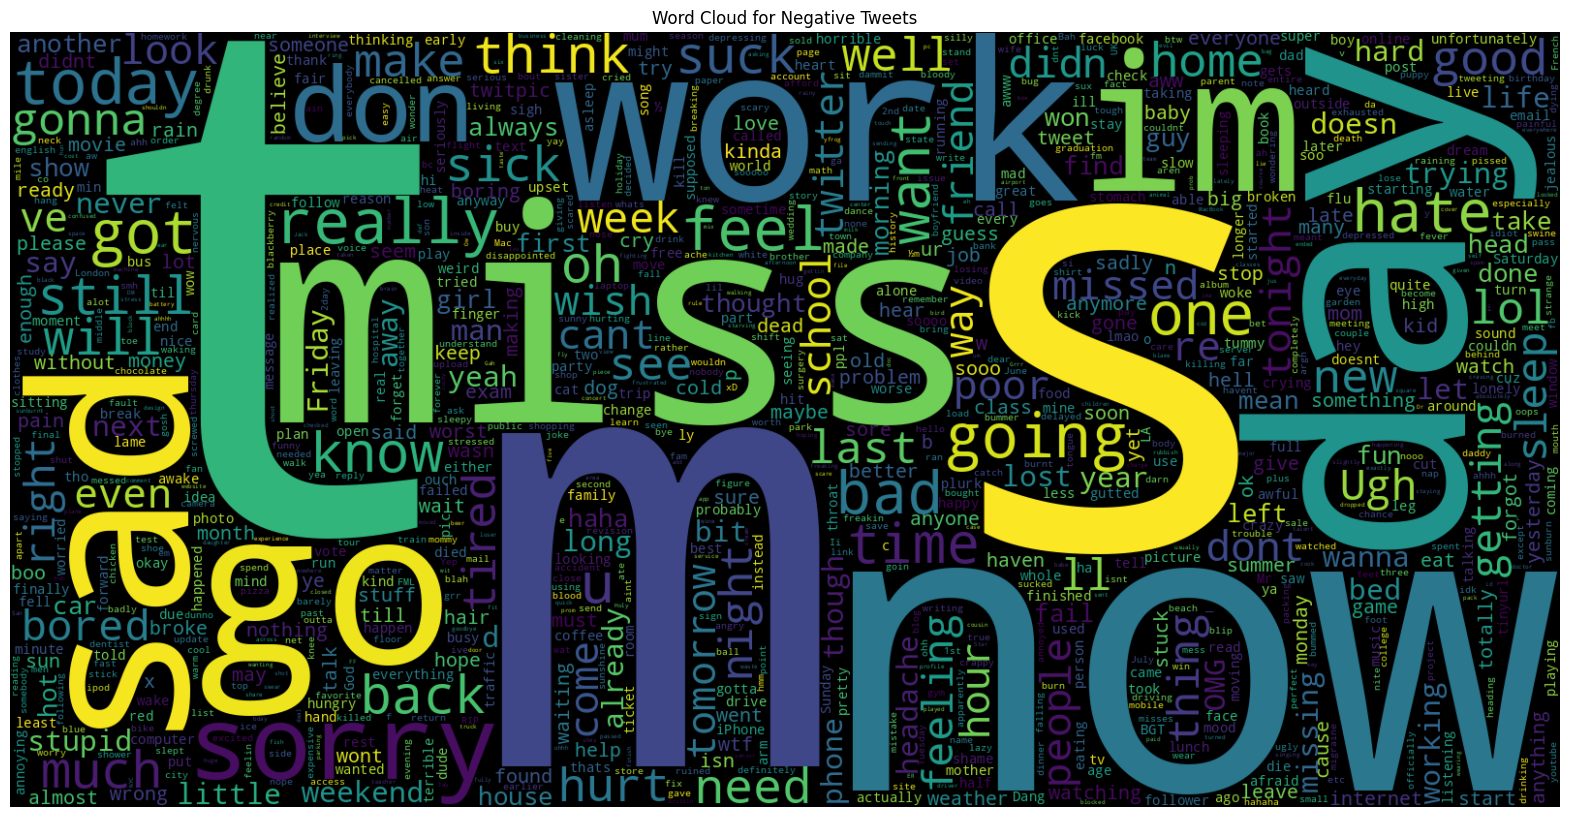

In [ ]:
# Divide the combined dataset into subsets
size = 27480  # Total size of the combined dataset

# Approximate size for each sentiment category based on original split
size_pos = int(size * len(data_pos) / len(dataset))
size_neg = int(size * len(data_neg) / len(dataset))
size_neu = size - size_pos - size_neg  # Remaining size for neutral

# Extract text for each sentiment category
text_pos = " ".join(data_pos['text'][:size_pos])
text_neg = " ".join(data_neg['text'][:size_neg])
text_neu = " ".join(data_neu['text'][:size_neu])

# Plot a cloud of words for negative tweets
plt.figure(figsize=(20, 20))
wc_neg = WordCloud(max_words=1000, width=1600, height=800,
                   collocations=False).generate(text_neg)
plt.title('Word Cloud for Negative Tweets')
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.show()

# Plot a cloud of words for positive tweets
plt.figure(figsize=(20, 20))
wc_pos = WordCloud(max_words=1000, width=1600, height=800,
                   collocations=False).generate(text_pos)
plt.title('Word Cloud for Positive Tweets')
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.show()

# Plot a cloud of words for neutral tweets
plt.figure(figsize=(20, 20))
wc_neu = WordCloud(max_words=1000, width=1600, height=800,
                   collocations=False).generate(text_neu)
plt.title('Word Cloud for Neutral Tweets')
plt.imshow(wc_neu, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
data["text"].shape

(27480,)

**Splitting our data into Train and Test Subset  :**

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=26105111)

random_state is basically used for reproducing your problem the same every time it is run. If we do not use a random_state in train_test_split, every time you make the split we might get a different set of train and test data points and will not help in debugging in case we get an issue.

X contains data.text

y contains = data.target

X_train contains 95% of data.text

X_test contains 5% of data.text

y_train contains 95% of data.target

y_test contains 5% of data.target

**Transforming Dataset using TF-IDF Vectorizer :**

Scikit-learn's Tfidftransformer and Tfidfvectorizer aim to do the same thing, which is to convert a collection of raw documents to a matrix of TF-IDF features.

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(data['text'], y, test_size=0.05, random_state=26105111)

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from google.colab import files

# Step 1: Fit the TfidfVectorizer on your training data
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)  # Ensure X_train is your training data

# Step 2: Save the fitted TfidfVectorizer to a file
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectoriser, file)

# Step 3: Download the saved file
files.download('tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Transform the data using TF-IDF Vectorizer :
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
X_test

<1374x172749 sparse matrix of type '<class 'numpy.float64'>'
	with 23507 stored elements in Compressed Sparse Row format>

After training the model we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively :

Accuracy Score : Typically, the accuracy of a predictive model is good (above 90% accuracy)
ROC-AUC Curve : The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
Confusion Matrix with Plot : A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model.
Actual values are the columns.
Predicted values are the lines.


Training Logistic Regression...
Logistic Regression trained successfully.
Evaluating model: Logistic Regression
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.71      0.59      0.64       382
           1       0.81      0.74      0.77       447
           2       0.62      0.74      0.68       545

    accuracy                           0.70      1374
   macro avg       0.71      0.69      0.70      1374
weighted avg       0.71      0.70      0.70      1374



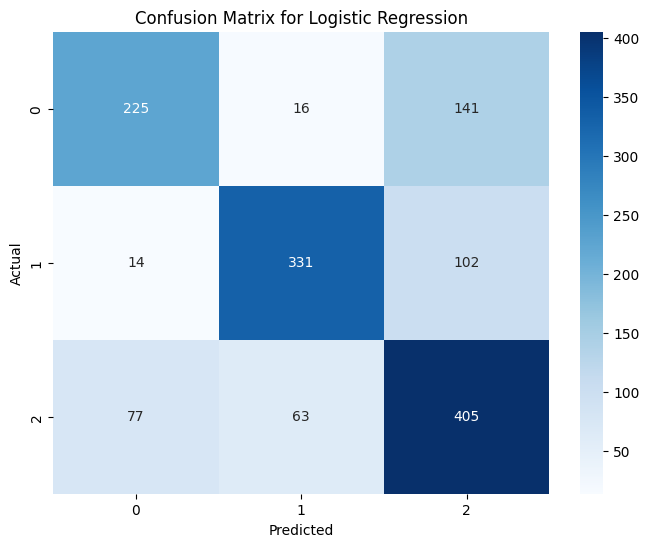

Logistic Regression evaluation completed.

Training Linear SVC...


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC trained successfully.
Evaluating model: Linear SVC
Classification Report for Linear SVC:

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       382
           1       0.77      0.76      0.77       447
           2       0.64      0.67      0.65       545

    accuracy                           0.69      1374
   macro avg       0.70      0.69      0.70      1374
weighted avg       0.69      0.69      0.69      1374



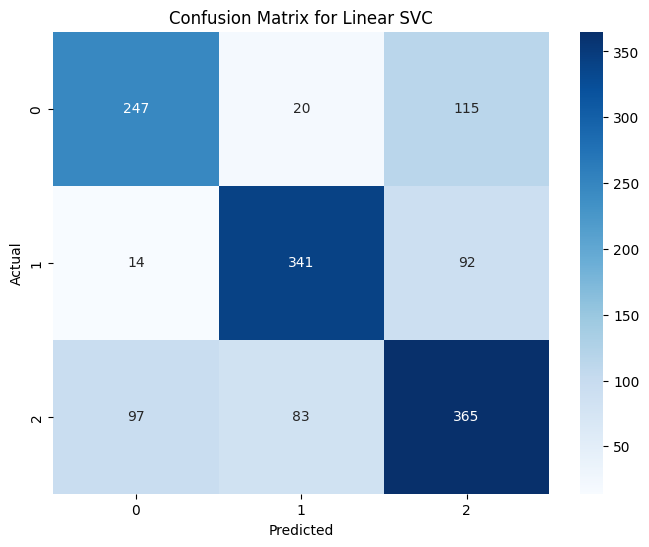

Linear SVC evaluation completed.

Training Naive Bayes...
Naive Bayes trained successfully.
Evaluating model: Naive Bayes
Classification Report for Naive Bayes:

              precision    recall  f1-score   support

           0       0.82      0.27      0.41       382
           1       0.86      0.51      0.65       447
           2       0.50      0.91      0.65       545

    accuracy                           0.60      1374
   macro avg       0.73      0.56      0.57      1374
weighted avg       0.71      0.60      0.58      1374



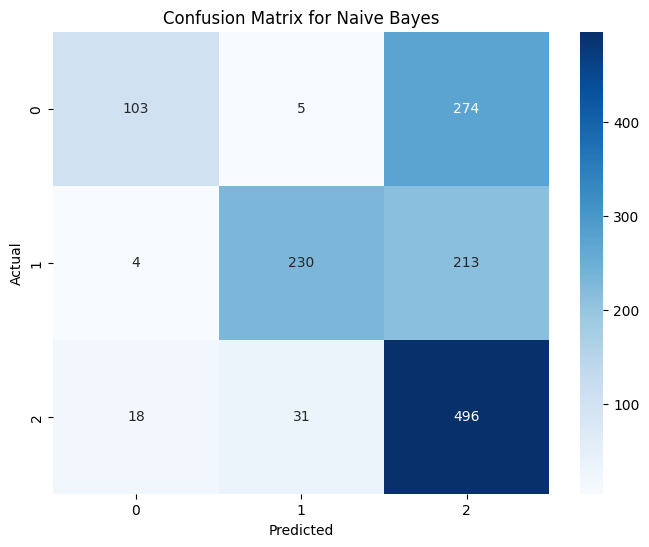

Naive Bayes evaluation completed.

Training Decision Tree...
Decision Tree trained successfully.
Evaluating model: Decision Tree
Classification Report for Decision Tree:

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       382
           1       0.72      0.69      0.70       447
           2       0.61      0.63      0.62       545

    accuracy                           0.63      1374
   macro avg       0.63      0.63      0.63      1374
weighted avg       0.63      0.63      0.63      1374



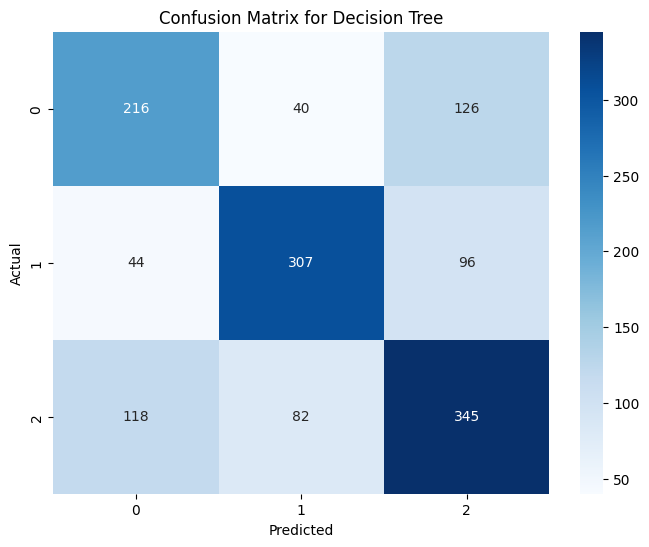

Decision Tree evaluation completed.

Training Random Forest...
Random Forest trained successfully.
Evaluating model: Random Forest
Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.77      0.48      0.60       382
           1       0.81      0.70      0.75       447
           2       0.59      0.81      0.68       545

    accuracy                           0.68      1374
   macro avg       0.72      0.66      0.68      1374
weighted avg       0.71      0.68      0.68      1374



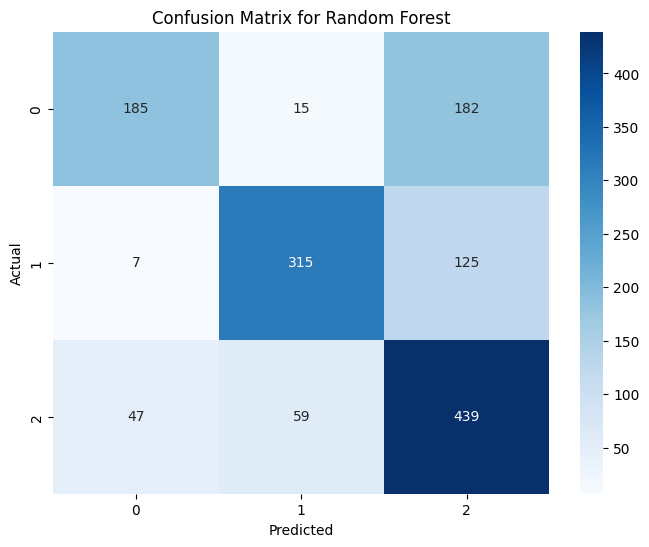

Random Forest evaluation completed.

Training K-Nearest Neighbors...
K-Nearest Neighbors trained successfully.
Evaluating model: K-Nearest Neighbors
Classification Report for K-Nearest Neighbors:

              precision    recall  f1-score   support

           0       0.45      0.54      0.49       382
           1       0.72      0.49      0.58       447
           2       0.53      0.59      0.56       545

    accuracy                           0.55      1374
   macro avg       0.57      0.54      0.54      1374
weighted avg       0.57      0.55      0.55      1374



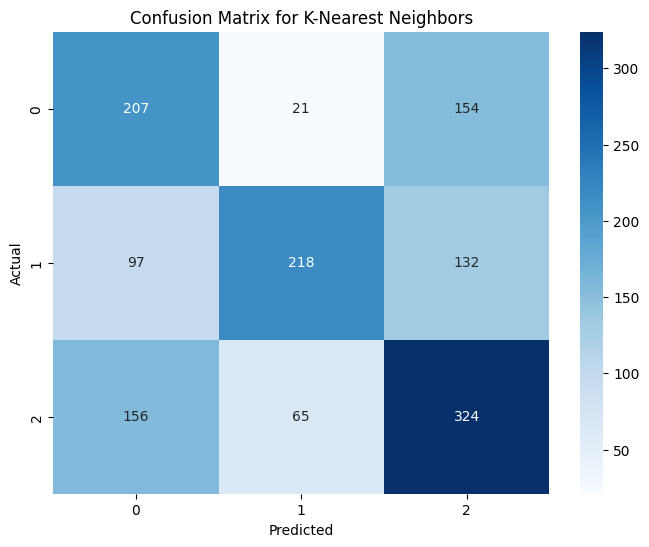

K-Nearest Neighbors evaluation completed.

Training Gradient Boosting...
Gradient Boosting trained successfully.
Evaluating model: Gradient Boosting
Classification Report for Gradient Boosting:

              precision    recall  f1-score   support

           0       0.78      0.41      0.54       382
           1       0.80      0.62      0.70       447
           2       0.56      0.84      0.67       545

    accuracy                           0.65      1374
   macro avg       0.71      0.63      0.64      1374
weighted avg       0.70      0.65      0.64      1374



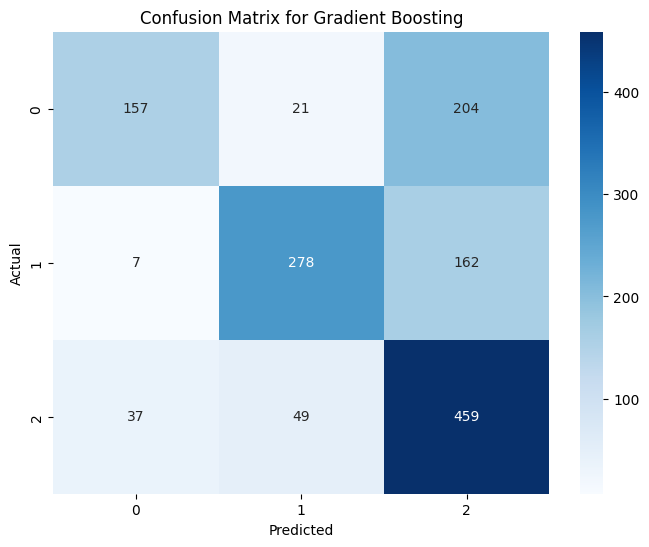

Gradient Boosting evaluation completed.

Training XGBoost...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:22:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained successfully.
Evaluating model: XGBoost
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.77      0.53      0.63       382
           1       0.82      0.70      0.75       447
           2       0.61      0.81      0.69       545

    accuracy                           0.70      1374
   macro avg       0.73      0.68      0.69      1374
weighted avg       0.72      0.70      0.70      1374



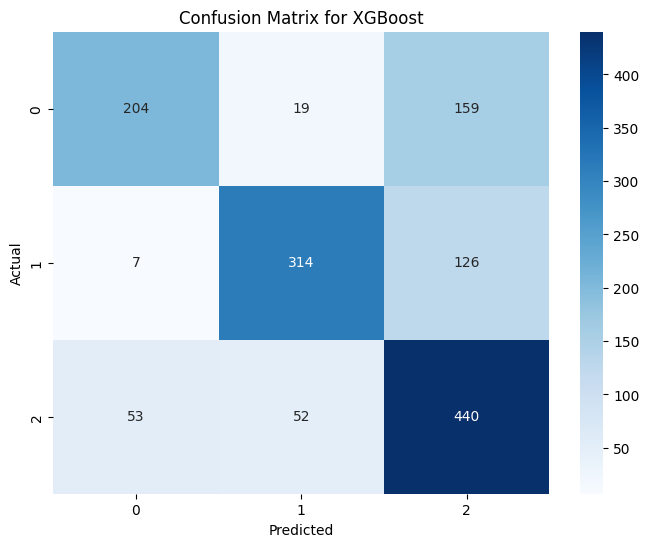

XGBoost evaluation completed.

Training AdaBoost...
AdaBoost trained successfully.
Evaluating model: AdaBoost
Classification Report for AdaBoost:

              precision    recall  f1-score   support

           0       0.78      0.41      0.54       382
           1       0.79      0.70      0.74       447
           2       0.58      0.82      0.68       545

    accuracy                           0.67      1374
   macro avg       0.72      0.64      0.65      1374
weighted avg       0.70      0.67      0.66      1374



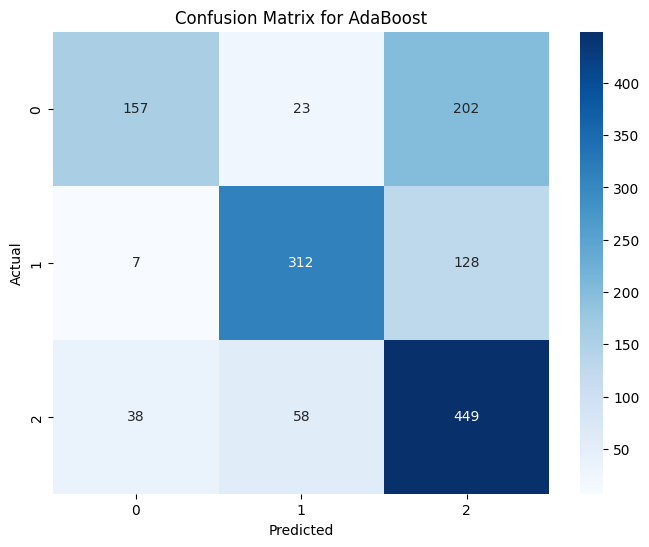

AdaBoost evaluation completed.

All models evaluated.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns



# Initialize classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Linear SVC': LinearSVC(),
    'Naive Bayes': MultinomialNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'AdaBoost': AdaBoostClassifier()
}

# Training and evaluating models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    print(f"{model_name} trained successfully.")

    print(f"Evaluating model: {model_name}")
    y_pred = model.predict(X_test)

    # Classification Report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    if len(np.unique(y)) == 2:
        # Binary classification
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()

    print(f"{model_name} evaluation completed.\n")

print("All models evaluated.")


In [ ]:


# Step 2: Import libraries
import xgboost as xgb
from sklearn.metrics import classification_report
from joblib import dump
from google.colab import files


# Step 4: Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
print("XGBoost trained successfully.")

# Step 5: Evaluate the model
y_pred = xgb_model.predict(X_test)
print("Classification Report for XGBoost:\n")
print(classification_report(y_test, y_pred))

# Step 6: Save the model with joblib in compressed format
dump(xgb_model, 'xgboost_model_compressed.joblib', compress=3)
print("Model saved and compressed successfully.")

# Step 7: Download the model file
files.download('xgboost_model_compressed.joblib')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:55:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained successfully.
Classification Report for XGBoost:

              precision    recall  f1-score   support

           0       0.77      0.53      0.63       382
           1       0.82      0.70      0.75       447
           2       0.61      0.81      0.69       545

    accuracy                           0.70      1374
   macro avg       0.73      0.68      0.69      1374
weighted avg       0.72      0.70      0.70      1374

Model saved and compressed successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>